In [102]:
import pandas as pd

# Load the uploaded data files
acs_data = pd.read_csv('/Users/michael/Desktop/SpringData2024-main/data/datathon_data/acs_5yr_est_2021.csv')
sentiment_regress_data = pd.read_csv('/Users/michael/Desktop/SpringData2024-main/data/regression/sentiment_regress.csv')

# Display the first few rows of each dataset to understand their structure
(acs_data.head(), sentiment_regress_data.head())

(                   Label (Grouping)           Category    State   Estimate  \
 0                 EMPLOYMENT STATUS             Header  Alabama        NaN   
 1      Population 16 years and over  EMPLOYMENT STATUS  Alabama  4,005,499   
 2                    In labor force  EMPLOYMENT STATUS  Alabama  2,313,616   
 3              Civilian labor force  EMPLOYMENT STATUS  Alabama  2,298,013   
 4                          Employed  EMPLOYMENT STATUS  Alabama  2,173,597   
 
   Margin of Error    Percent Percent Margin of Error  Year  
 0             NaN        NaN                     NaN  2021  
 1          ±1,780  4,005,499                     (X)  2021  
 2          ±8,825      57.8%                    ±0.2  2021  
 3          ±8,669      57.4%                    ±0.2  2021  
 4          ±8,587      54.3%                    ±0.2  2021  ,
   State  Drill    co2  drill_diff  co2_diff
 0    AL  61.39  67.15   10.762353 -3.742157
 1    AK  48.40  69.14   -2.227647 -1.752157
 2    AZ  52.80 

In [103]:
# Preparing the ACS data: selecting only numerical columns and transforming them for analysis
# The ACS dataset requires cleaning of the 'Estimate' column to remove commas and convert to numeric

# Identify numerical columns - focusing on 'Estimate' as it contains the relevant data
acs_data['Estimate'] = pd.to_numeric(acs_data['Estimate'].str.replace(',', ''), errors='coerce')

# Dropping non-numeric and unnecessary columns for this analysis
acs_numeric = acs_data[['State', 'Estimate']].dropna()

# Since ACS data might have multiple rows per state due to various categories, we need a strategy to aggregate these values
# A simple approach could be to take the mean of 'Estimate' per state, but let's see the structure first
acs_grouped = acs_numeric.groupby('State').mean().reset_index()

# Merge ACS data with sentiment regress data on 'State'
merged_data = pd.merge(acs_grouped, sentiment_regress_data[['State', 'co2_diff']], on='State', how='inner')

# Check the merged data structure
merged_data.head()

,State,Estimate,co2_diff


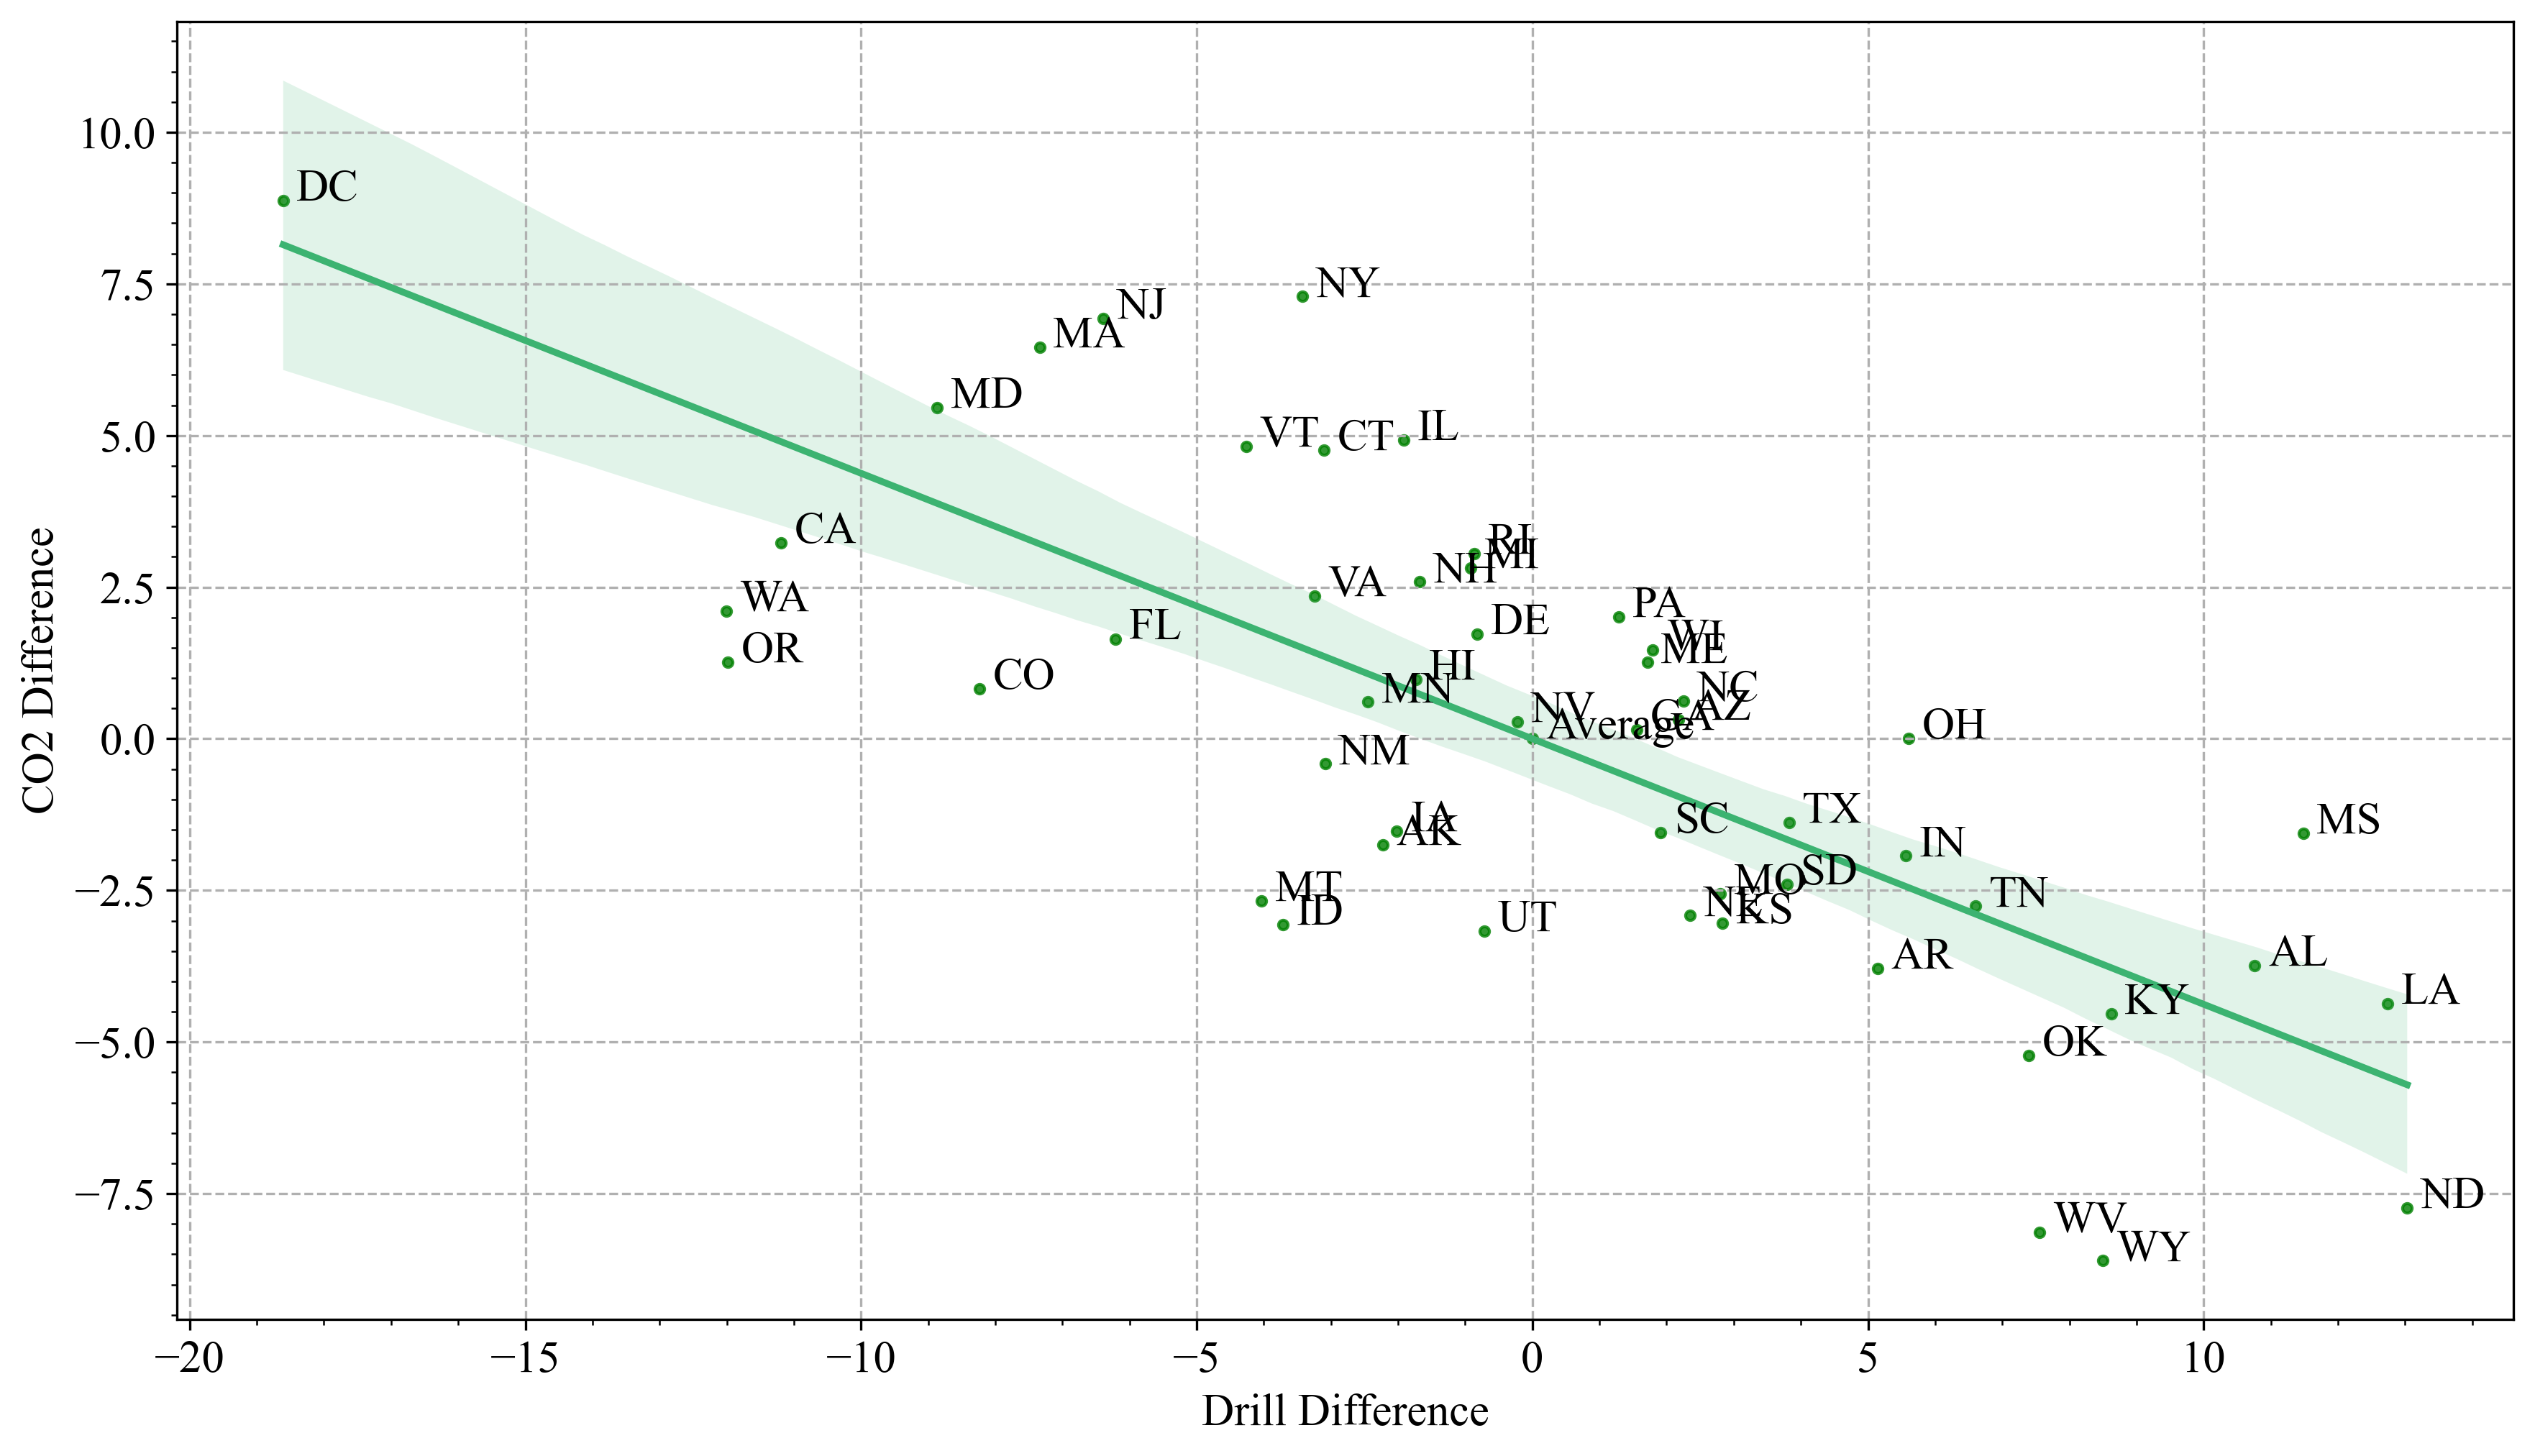

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set global font to Times New Roman
mpl.rcParams['font.family'] = 'Times New Roman'

# Setting up the figure for the regression plot with higher resolution
fig, ax = plt.subplots(figsize=(12, 7), dpi=300)

# Regression plot for Drill Difference vs. CO2 Difference with state labels
sns.regplot(x='drill_diff', y='co2_diff', data=sentiment_regress_data, color='green', scatter_kws={'s': 10}, line_kws={'color': 'mediumseagreen'}, ax=ax)

for line in range(0, sentiment_regress_data.shape[0]):
     ax.text(sentiment_regress_data.drill_diff[line]+0.2, sentiment_regress_data.co2_diff[line], 
     sentiment_regress_data.State[line], horizontalalignment='left', 
     size='medium', color='black', weight='normal')

# Enable minor ticks
ax.minorticks_on()

# Enable minor grid lines
ax.grid(which='major', linestyle='--')

# Increase the size of the axes numbers
ax.tick_params(axis='both', which='major', labelsize=15)

# Increase the size of the axes labels
ax.set_xlabel('Drill Difference', fontsize=15)
ax.set_ylabel('CO2 Difference', fontsize=15)

plt.tight_layout()
plt.show()

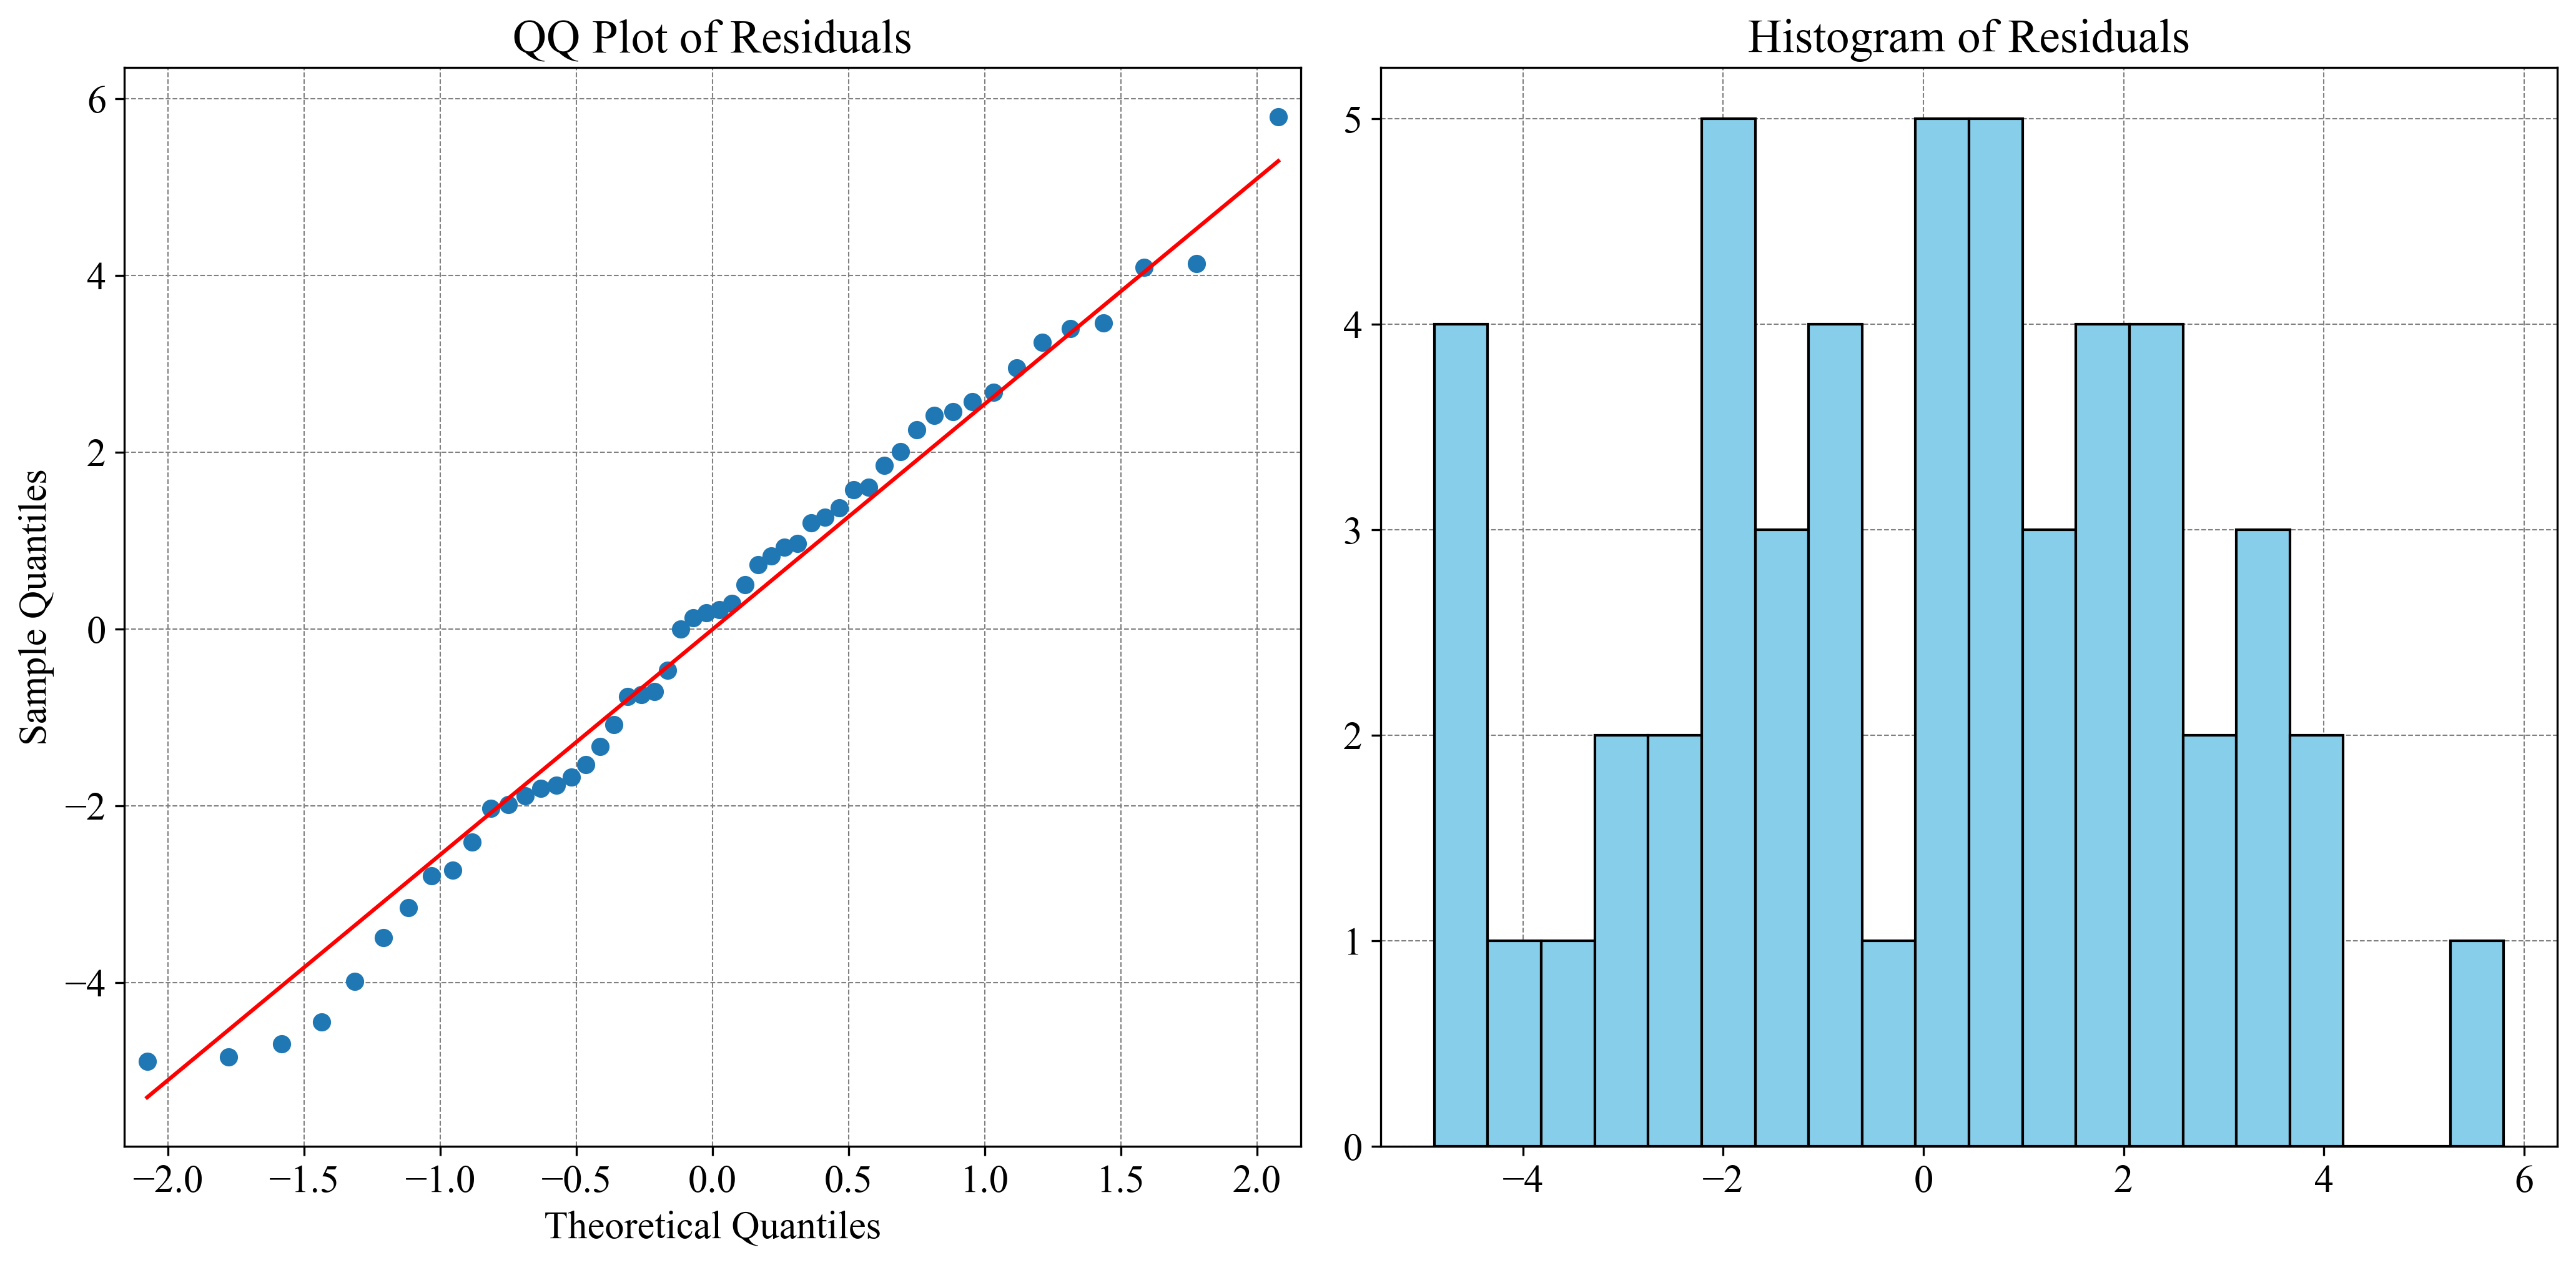

In [105]:
from scipy import stats
import statsmodels.api as sm
import matplotlib as mpl

# Set global font size
mpl.rcParams['font.size'] = 15

# Perform linear regression to obtain residuals
X = sentiment_regress_data['drill_diff']
y = sentiment_regress_data['co2_diff']
X = sm.add_constant(X)  # Adds a constant term to the predictor
model = sm.OLS(y, X)
results = model.fit()

# Obtain residuals
residuals = results.resid

# Creating subplots for the QQ plot and the histogram of residuals
fig, ax = plt.subplots(1, 2, figsize=(14, 7), dpi=300)

# QQ plot of residuals
qq = sm.qqplot(residuals, line='s', ax=ax[0])
qq_line = qq.axes[0].get_lines()[0]
qq_line.set_color('green')
ax[0].set_title('QQ Plot of Residuals')

# Add dashed grid to QQ plot
ax[0].grid(True, linestyle='--', which='both', color='gray', linewidth=0.5)
ax[0].set_axisbelow(True)  # Set grid lines behind other graph elements

# Histogram of residuals
ax[1].hist(residuals, bins=20, color='skyblue', edgecolor='black')
ax[1].set_title('Histogram of Residuals')

# Add dashed grid to histogram
ax[1].grid(True, linestyle='--', which='both', color='gray', linewidth=0.5)
ax[1].set_axisbelow(True)  # Set grid lines behind other graph elements

plt.tight_layout()
plt.show()